In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

from scipy.optimize import minimize

In [2]:
START_YEAR = 1990
END_YEAR = 2005
INTERVENTION_YEAR = 2001
TARGET_COUNTRY = 'UNITED KINGDOM'
DONOR_COUNTRIES = [
    'ARGENTINA', 'AUSTRALIA', 'AUSTRIA', 'BAHAMAS', 'BAHRAIN', 'BARBADOS',
    'BELGIUM', 'BOTSWANA', 'BRAZIL', 'BRUNEI (DARUSSALAM)', 'CANADA',
    'CHILE', 'CYPRUS', 'FRANCE (INCLUDING MONACO)', 'GABON',
    'GREECE', 'HONG KONG SPECIAL ADMINSTRATIVE REGION OF CHINA', 'HUNGARY',
    'ICELAND', 'IRELAND', 'ISRAEL', 'ITALY (INCLUDING SAN MARINO)', 
    'JAPAN', 'KUWAIT', 'LEBANON', 'LIBYAN ARAB JAMAHIRIYAH', 'LUXEMBOURG',
    'MACAU SPECIAL ADMINSTRATIVE REGION OF CHINA', 'MALAYSIA', 'MALTA',
    'MAURITIUS', 'MEXICO', 'NEW ZEALAND', 'OMAN', 'PANAMA', 'POLAND', 
    'PORTUGAL', 'QATAR', 'REPUBLIC OF KOREA', 'SAUDI ARABIA', 'SINGAPORE',
    'SOUTH AFRICA', 'SPAIN', 'SWITZERLAND', 'TRINIDAD AND TOBAGO', 
    'TURKEY', 'UNITED ARAB EMIRATES', 'UNITED STATES OF AMERICA',
    'URUGUAY','VENEZUELA',
]

# 'GERMANY', removed from analysis due to missing 1990 value

Load and perpare the data

In [3]:
# Read data from a CSV file
data = pd.read_csv('data/nation.1751_2014.csv')

# Remove the first three rows which contain metadata, not actual data, 
# then filter the DataFrame based on specified countries and the year range
data = data \
    .loc[3:, :] \
    .query(f'Nation in {[TARGET_COUNTRY] + DONOR_COUNTRIES}') \
    .query((f'Year >= {START_YEAR} & Year <= {END_YEAR}')) \
    .reset_index(drop=True)

# Rename the columns for readability
data.columns = [
    'nation',
    'year',
    'total_CO2',
    'solid_CO2',
    'liquid_CO2',
    'gas_CO2',
    'cement_CO2',
    'gas_flaring_emission',
    'per_capita_CO2',
    'bunker_fuel_emissions',
]

# Select columns with 'object' data type, excluding the 'nation' column
object_columns_to_convert = [col for col in data.select_dtypes(include='object').columns if col != 'nation']

# Convert each of these columns to numeric data types
for col in object_columns_to_convert:
    data[col] = pd.to_numeric(data[col])

# Convert the 'year' column to integer data type
data['year'] = data['year'].astype(int)

data.head()


,nation,year,total_CO2,solid_CO2,liquid_CO2,gas_CO2,cement_CO2,gas_flaring_emission,per_capita_CO2,bunker_fuel_emissions
0,ARGENTINA,1990,30583.0,838,16154,11794,491.0,1306,0.94,628.0
1,ARGENTINA,1991,31933.0,734,16712,12905,462.0,1120,0.96,410.0
2,ARGENTINA,1992,33093.0,765,17367,13183,687.0,1091,0.99,415.0
3,ARGENTINA,1993,32159.0,628,18327,11137,768.0,1297,0.95,332.0
4,ARGENTINA,1994,33381.0,972,18342,11648,854.0,1566,0.97,334.0


Plot the naive control (simple average of donor pool)

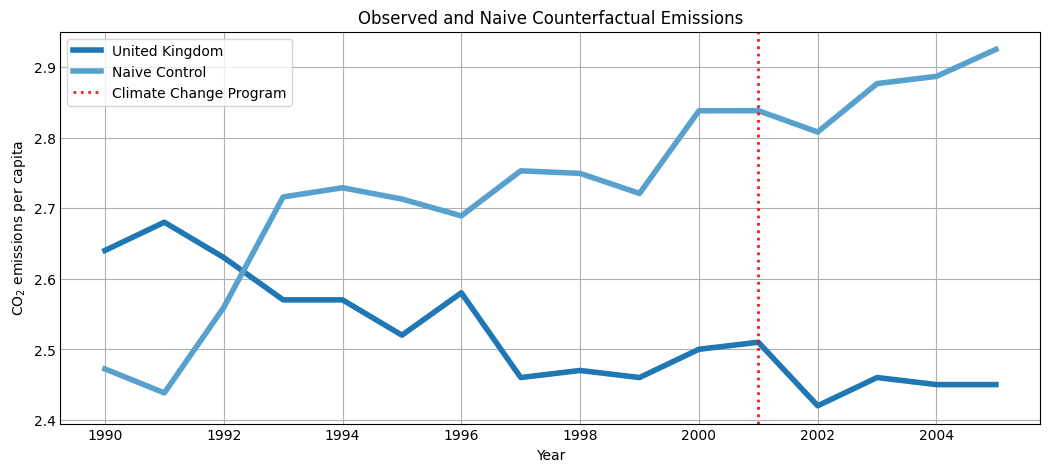

In [4]:
plt.figure(figsize=(10,4))

ax = plt.subplot(1, 1, 1)

pivot_data = data \
    .assign(united_kingdom = np.where(data['nation'] == TARGET_COUNTRY, 'United Kingdom', 'Other Countries')) \
    .groupby(['year', 'united_kingdom']) \
    ['per_capita_CO2'] \
    .mean() \
    .reset_index() \
    .pivot(
        index='year', 
        columns='united_kingdom', 
        values='per_capita_CO2'
    )
    
pivot_data['United Kingdom'].plot(ax=ax,lw=4)
pivot_data['Other Countries'].plot(ax=ax, lw=4, label='Naive Control')

ax.axvline(x=INTERVENTION_YEAR, linestyle=":", color='red', lw=2, alpha=0.9, label='Climate Change Program')
ax.set_xlabel('Year')
ax.set_ylabel('CO$_2$ emissions per capita')
ax.set_title('Observed and Naive Counterfactual Emissions')
ax.legend()
plt.show()

Find the weights that minimize the Mean Squared Prediction Error between the observed and synthetic control

In [5]:
# Define a function to calculate the mean squared prediction error (MSPE)
def calculate_mspe(W, X, y):
    return np.mean((y - X.dot(W))**2)

# Define the features to be used
features = ['per_capita_CO2']

# Create a pre-intervention feature matrix
pre_intervention_feature_matrix = data \
    .query(f'year < {INTERVENTION_YEAR}') \
    .pivot(index='nation', columns='year') \
    [features] \
    .T

# Extract values for the donor countries as features and the treatment country as a target
X = pre_intervention_feature_matrix[DONOR_COUNTRIES].values 
y = pre_intervention_feature_matrix[TARGET_COUNTRY].values

# Define a function to optimize the weights using MSPE as the loss function
def optimize_weights(X, y):
    
    len_w = X.shape[1]
    initial_weights = np.full(shape=len_w, fill_value=1/len_w)  # Initialize weights to be equal

    # Perform optimization to minimize the MSPE, 
    # subject to individual weights being bounded between 0 and 1
    # and all weights summing to 1
    optimization_results = minimize(
        fun=calculate_mspe, 
        x0=initial_weights, 
        args=(X, y), 
        bounds=[(0.0, 1.0)] * len_w, 
        constraints={'type': 'eq', 'fun': lambda x: x.sum() - 1},
    )
    
    return optimization_results.x


# Apply the optimize_weights function to get the weights for the sythetic control
weights_synthetic_control = optimize_weights(X, y)

# Print the weights array and their sum
print("Sum of the weights:", weights_synthetic_control.sum())
print("\nWeights:\n\n", weights_synthetic_control)

Sum of the weights: 1.0

Weights:

 [1.57292414e-02 0.00000000e+00 4.01882400e-02 1.77105426e-01
 2.34458720e-18 2.71050543e-19 1.38656145e-01 1.18831474e-03
 1.97759141e-03 1.31509675e-02 4.20128342e-19 0.00000000e+00
 0.00000000e+00 6.43974044e-02 1.03970483e-03 0.00000000e+00
 0.00000000e+00 2.51969031e-02 0.00000000e+00 3.65918233e-19
 4.63713247e-04 1.89220852e-02 6.82084545e-02 2.03287907e-19
 0.00000000e+00 1.48718614e-01 5.28080856e-02 0.00000000e+00
 3.16560781e-02 0.00000000e+00 1.29919373e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.83743872e-03 8.94828587e-02
 0.00000000e+00 1.64979279e-03 0.00000000e+00 0.00000000e+00
 1.77776342e-03 1.72201952e-02 1.52110209e-03 2.89425318e-02
 5.62488902e-02 3.21882126e-04 8.13151629e-20 7.58941521e-19
 2.91382447e-04 0.00000000e+00]


Plot synthetic control weights

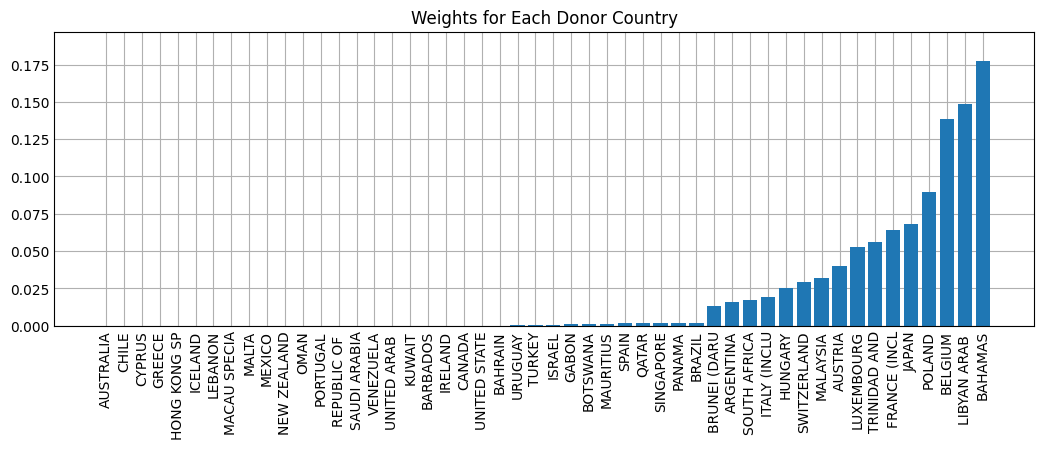

In [6]:
# Combine countries and weights into pairs and sort by weights
sorted_pairs = sorted(zip(weights_synthetic_control, DONOR_COUNTRIES))
sorted_weights, sorted_countries = zip(*sorted_pairs)

# Create vertical bar chart
plt.figure(figsize=(10, 3))
plt.bar(sorted_countries, sorted_weights, width=0.8)

# Add labels
plt.title('Weights for Each Donor Country')
plt.ylim(0, max(sorted_weights) + 0.02)  # Set y-limit to be slightly higher than the max weight
x_ticks_labels = [label.get_text()[:12] for label in plt.gca().get_xticklabels()]  # truncate x-axis labels
plt.xticks(ticks=range(len(x_ticks_labels)), labels=x_ticks_labels, rotation=90)

plt.show()


Plot error in each year for the naive control (simple average) and the synthetic control (weighted average)

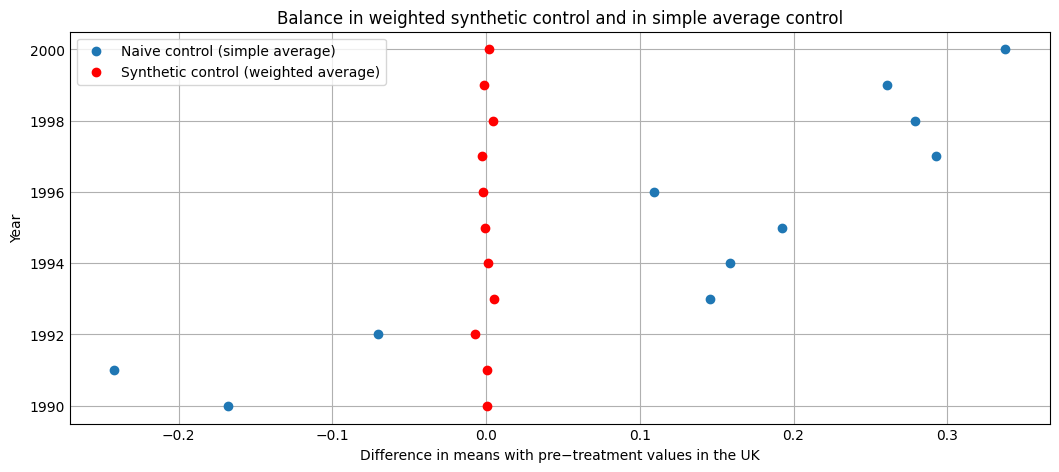

In [7]:
# Apply weights to donor pool to get synthetic control for UK
synthetic_uk = data \
    .query(f'nation != "{TARGET_COUNTRY}"') \
    .pivot(index='year', columns='nation') \
    ['per_capita_CO2'] \
    .values \
    .dot(weights_synthetic_control)

# Extract pre-treatment observed and synthetic values
uk_pre_intervention = pivot_data.reset_index().query(f'year < {INTERVENTION_YEAR}')['United Kingdom']
naive_pre_intervention = pivot_data.reset_index().query(f'year < {INTERVENTION_YEAR}')['Other Countries']

# Define the years in the pre_treatment period
years_pre_intervention = data.query(f'year < {INTERVENTION_YEAR}')['year'].unique() 

plt.figure(figsize=(10, 4))

# Plot error between the pre-treatment observed and simple average  
plt.scatter(naive_pre_intervention - uk_pre_intervention, years_pre_intervention, label='Naive control (simple average)')

# Plot error between the pre-treatment observed and weighted average (synthetic control)  
plt.scatter(synthetic_uk[:len(years_pre_intervention)] - uk_pre_intervention, years_pre_intervention, color='red', label='Synthetic control (weighted average)')

# Add labels and legend
plt.xlabel('Difference in means with pre−treatment values in the UK')
plt.ylabel('Year')
plt.title('Balance in weighted synthetic control and in simple average control')
plt.legend()

plt.show()

Plot the observed carbon emissions and the synthetic control

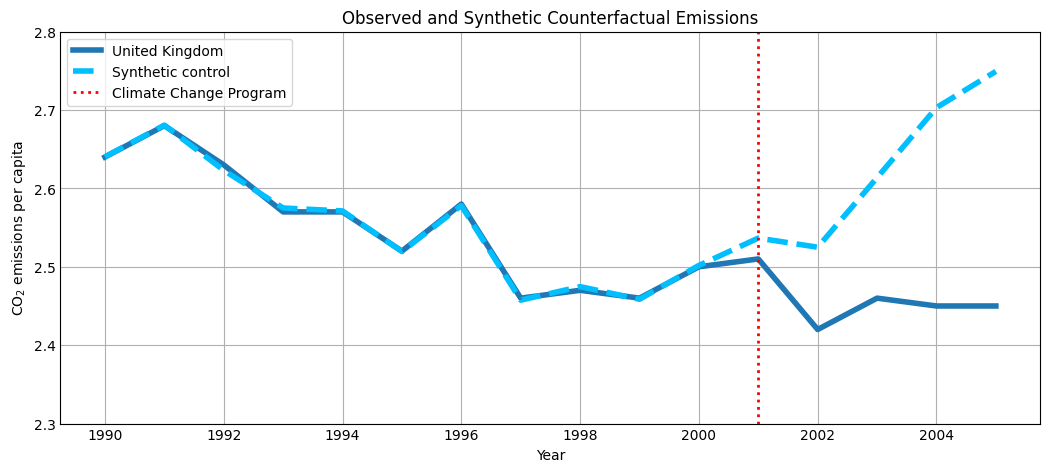

In [8]:
# Create a feature matrix of the donor countries for the entire time period
full_period_feature_matrix = data \
    .query(f'nation != "{TARGET_COUNTRY}"') \
    .pivot(index='year', columns='nation') \
    ['per_capita_CO2'] \
    .values

# Use the optimized weights to take the weighted average of the full feature matrix
synthetic_control = full_period_feature_matrix.dot(weights_synthetic_control)

# Plot synthetic control graph
plt.figure(figsize=(10, 4))

plt.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'], label='United Kingdom',
    lw=4,
)
plt.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    synthetic_control, label='Synthetic control',
        linestyle="--",
        lw=4,
        color='deepskyblue'
)
plt.axvline(x=INTERVENTION_YEAR, linestyle=':', color='red', lw=2, label='Climate Change Program')
plt.xlabel('Year')
plt.ylabel('CO$_2$ emissions per capita')
plt.title('Observed and Synthetic Counterfactual Emissions')
plt.ylim(2.3, 2.8)
plt.legend()

Report the estimated treatment effect

In [9]:
end_year_observed_CO2_UK = data.query(f'nation=="{TARGET_COUNTRY}" & year==2005').iloc[0]['per_capita_CO2']
index_UK = -1
effect_UK = end_year_observed_CO2_UK - synthetic_control[index_UK] 
effect_percent_UK = (end_year_observed_CO2_UK - synthetic_control[-1]) / end_year_observed_CO2_UK

print(f'United Kingdom Treatment Effect for the Year {END_YEAR}:', effect_UK)
print(f'United Kingdom Treatment Effect (%) for the Year {END_YEAR}:', f'{round(effect_percent_UK * 100, 2)}%')

United Kingdom Treatment Effect for the Year 2005: -0.29920933177815856
United Kingdom Treatment Effect (%) for the Year 2005: -12.21%


Plot these three graphs to be used in the accompanying Medium article

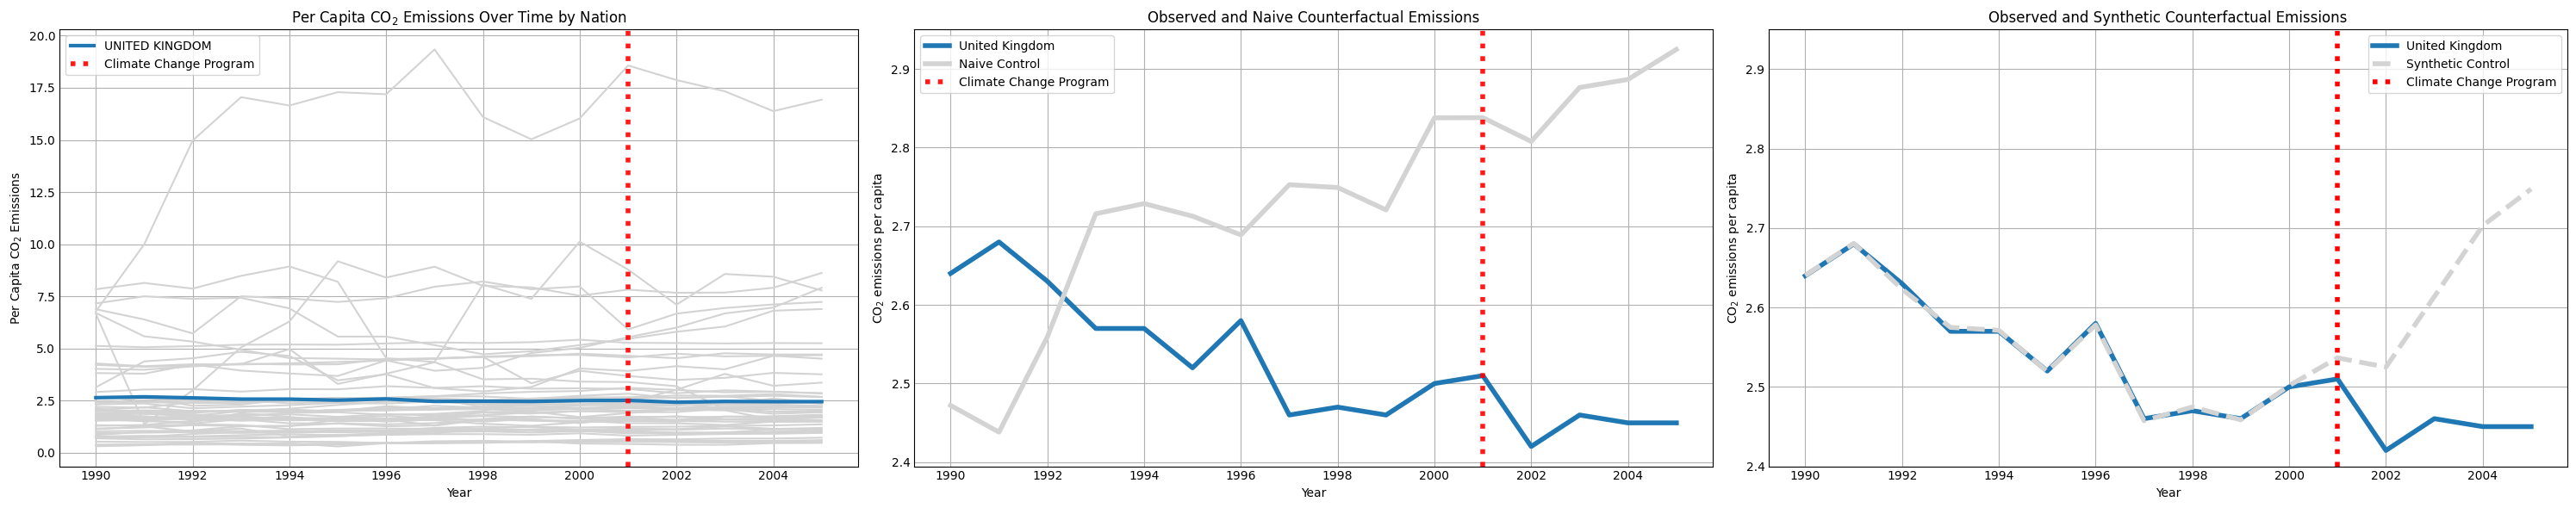

In [10]:
plt.figure(figsize=(30, 6))

# Plot emissions for each country
plt.subplot(1, 3, 1)  # First subplot in the 1x3 grid

sns.lineplot(
    x='year', y='per_capita_CO2', hue='nation', 
    data=data.query(f'nation in {DONOR_COUNTRIES}'), 
    palette=['lightgrey' for _ in range(len(DONOR_COUNTRIES))], 
    legend=False,
)
sns.lineplot(
    x='year', y='per_capita_CO2', 
    data=data.query(f'nation == "{TARGET_COUNTRY}"'), 
    color='C0', lw=3, label=TARGET_COUNTRY
)
plt.axvline(x=INTERVENTION_YEAR, linestyle=":", color='red', lw=4, alpha=0.9, label='Climate Change Program')
plt.title('Per Capita CO$_2$ Emissions Over Time by Nation')
plt.xlabel('Year')
plt.ylabel('Per Capita CO$_2$ Emissions')
plt.legend()

# Plot naive control
plt.subplot(1, 3, 2)  # Second subplot in the 1x3 grid

pivot_data_adjusted = data \
    .assign(united_kingdom = np.where(data['nation'] == TARGET_COUNTRY, 'United Kingdom', 'Other Countries')) \
    .groupby(['year', 'united_kingdom']) \
    ['per_capita_CO2'] \
    .mean() \
    .reset_index() \
    .pivot(
        index='year', 
        columns='united_kingdom', 
        values='per_capita_CO2'
    )
    
pivot_data_adjusted['United Kingdom'].plot(lw=4)
pivot_data_adjusted['Other Countries'].plot(lw=4, color='lightgrey', label='Naive Control')

plt.axvline(x=INTERVENTION_YEAR, linestyle=":", color='red', lw=4, alpha=0.9, label='Climate Change Program')
plt.xlabel('Year')
plt.ylabel('CO$_2$ emissions per capita')
plt.title('Observed and Naive Counterfactual Emissions')
plt.legend()

# Plot synthetic control graph
plt.subplot(1, 3, 3)  # Third subplot in the 1x3 grid

synthetic_control_adjusted = data \
    .query(f'nation != "{TARGET_COUNTRY}"') \
    .pivot(index='year', columns='nation') \
    ['per_capita_CO2'] \
    .values \
    .dot(weights_synthetic_control)

plt.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'], label='United Kingdom',
    lw=4,
)
plt.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    synthetic_control_adjusted, label='Synthetic Control',
    linestyle="--",
    lw=4,
    color='lightgrey'
)
plt.axvline(x=INTERVENTION_YEAR, linestyle=':', color='red', lw=4, label='Climate Change Program')
plt.xlabel('Year')
plt.ylabel('CO$_2$ emissions per capita')
plt.title('Observed and Synthetic Counterfactual Emissions')
plt.ylim(2.4, 2.95)
plt.legend()

plt.tight_layout()
plt.show()

Plot the treatment effect across time

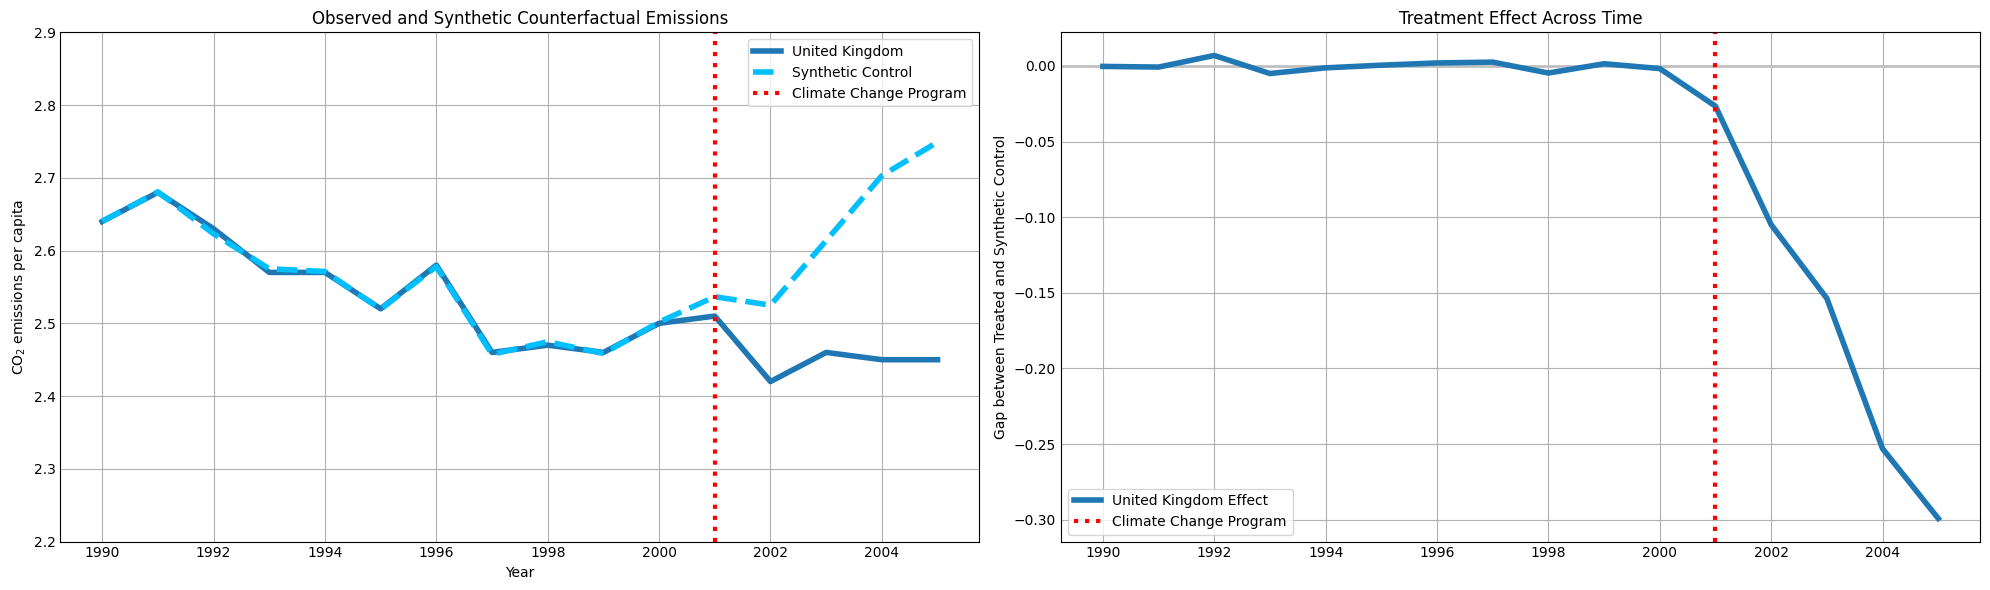

In [11]:
# Apply weights to the donor pool to get synthetic control for the UK 
synthetic_control = data \
    .query(f'nation != "{TARGET_COUNTRY}"') \
    .pivot(index='year', columns='nation') \
    ['per_capita_CO2'] \
    .values \
    .dot(weights_synthetic_control)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot carbon emissions for the observed and synthetic control
ax1.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'], label='United Kingdom',
    lw=4,
)
ax1.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    synthetic_control, label='Synthetic Control',
    linestyle="--",
    lw=4,
    color='deepskyblue'
)
ax1.axvline(x=INTERVENTION_YEAR, linestyle=':', color='red', lw=3, label='Climate Change Program')
ax1.set_xlabel('Year')
ax1.set_ylabel('CO$_2$ emissions per capita')
ax1.set_title('Observed and Synthetic Counterfactual Emissions')
ax1.set_ylim(2.2, 2.9)
ax1.legend()

# Plot the treatment effect across time
ax2.axhline(y=0, color='silver', lw=2)
ax2.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'] - synthetic_control,
    lw=4,
    label='United Kingdom Effect',
)
ax2.axvline(x=INTERVENTION_YEAR, linestyle=':', color='red', lw=3, label='Climate Change Program')
ax2.set_title('Treatment Effect Across Time')
ax2.set_ylabel('Gap between Treated and Synthetic Control')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

Perform placebo experiments, iteratively using each donor country as the treatment unit

In [12]:
def calculate_synthetic_control(nation, data, leave_one_out=[]):
    
    # Define the feature(s) to be used
    features = ['per_capita_CO2']

    # Create a pre-intervention feature matrix that is transposed
    pre_intervention_feature_matrix = data.query(f'year < {INTERVENTION_YEAR}') \
                .pivot(index='nation', columns="year") \
                [features] \
                .T

    # Remove countries from donor pool if doing 'leave-one-out' robustness check
    pre_intervention_feature_matrix = pre_intervention_feature_matrix.drop(columns=leave_one_out)
        
    
    # Extract values for the target country and control features
    X = pre_intervention_feature_matrix.drop(columns=nation).values 
    y = pre_intervention_feature_matrix[nation].values

    weights = optimize_weights(X, y)

    if not leave_one_out:
        synthetic = data \
            .query(f'nation != "{nation}"') \
            .pivot(index='year', columns="nation") \
            ['per_capita_CO2'] \
            .values \
            .dot(weights)
    
    # If doing leave-one-out placebo test
    else:
        synthetic = data \
            .query(f'nation not in {[TARGET_COUNTRY] + leave_one_out}') \
            .pivot(index='year', columns="nation") \
            ['per_capita_CO2'] \
            .values \
            .dot(weights)
    
    return data \
        .query(f'nation == "{nation}"') \
        [['nation', 'year', 'per_capita_CO2']] \
        .assign(synthetic=synthetic)
                
# Run the placebo experiments separately from the actual experiment,
# so that the target country is not included in the remaining countries used
# to build the placebo synthetic controls. A minor nuance that probably
# has little effect if violated.
actual_experiment = calculate_synthetic_control(nation=TARGET_COUNTRY, data=data)
placebo_experiments = [calculate_synthetic_control(nation=nation, data=data) for nation in DONOR_COUNTRIES]
all_experiments = placebo_experiments + [actual_experiment]

Plot individual placebo countries (carbon emissions for observed and synthetic control)

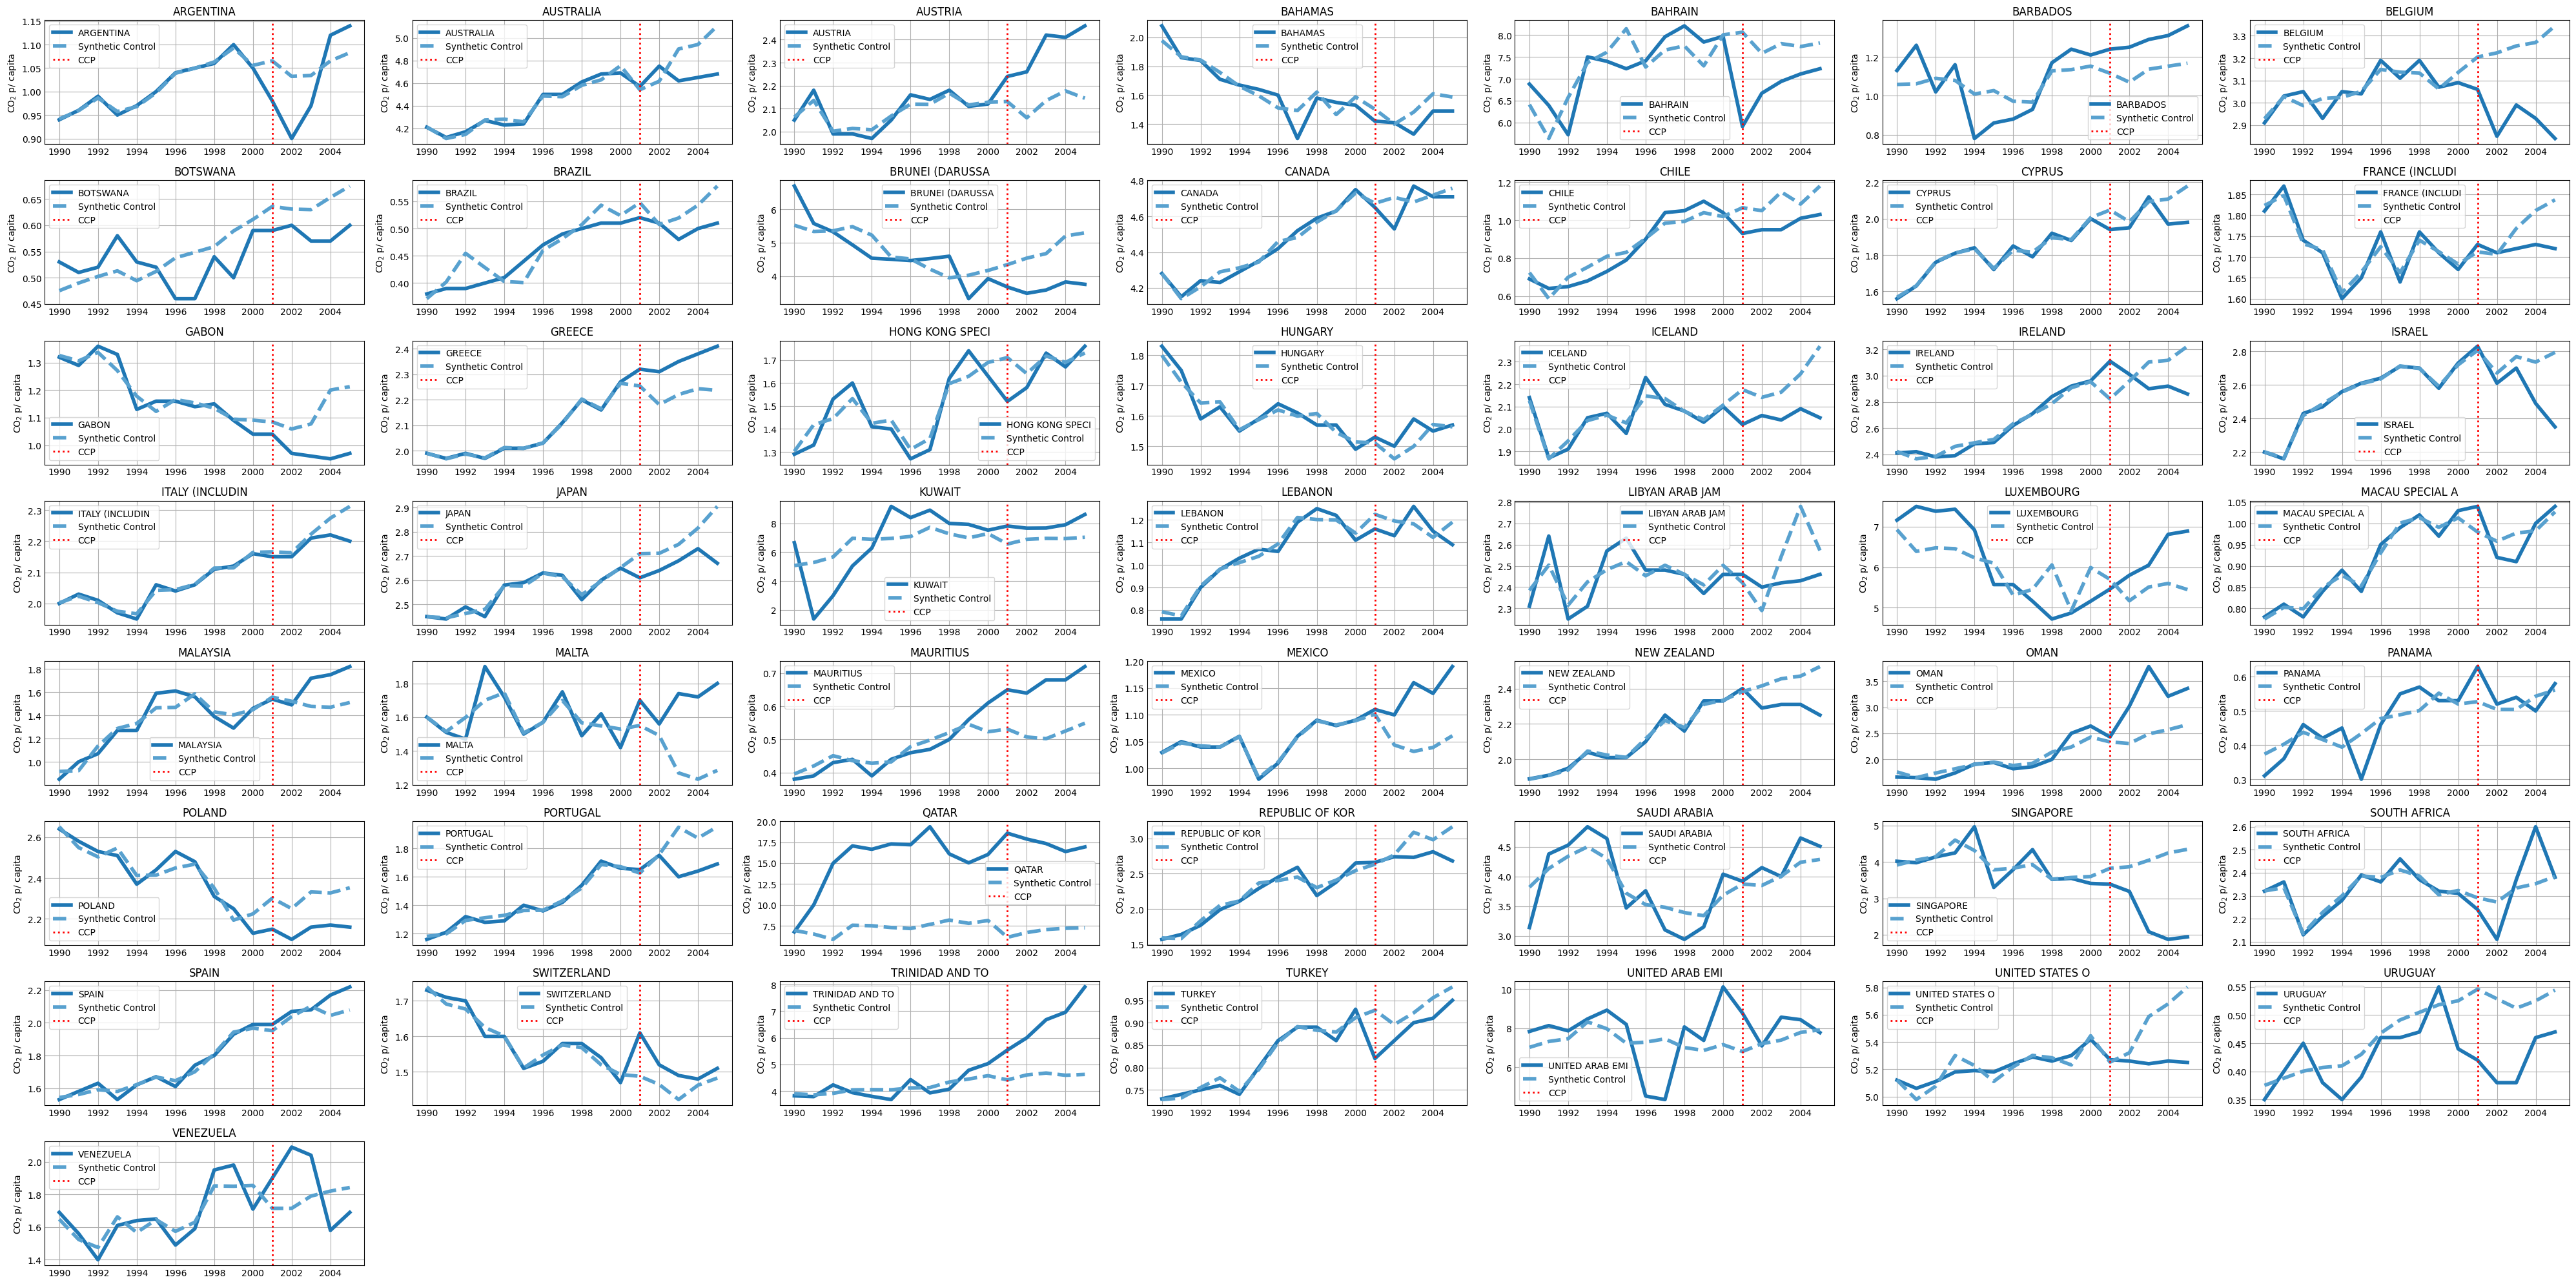

In [13]:
# Set up subplot grid
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40, 20)) # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes to iterate over them

for i, nation in enumerate(DONOR_COUNTRIES):
    ax = axes[i]
    
    # Query data for the current country
    nation_data = data \
        .query(f'nation == "{nation}"') \
        .query((f'year >= {START_YEAR} & year <= {END_YEAR}'))
    
    # Plot the data
    ax.plot(nation_data['year'], nation_data['per_capita_CO2'], lw=4, label=f'{nation[:15]}')
    ax.plot(nation_data['year'], placebo_experiments[i]['synthetic'], linestyle="--", lw=4, label='Synthetic Control')
    ax.axvline(x=INTERVENTION_YEAR, linestyle=":", lw=2, color='red', label='CCP')
    ax.set_ylabel('CO$_2$ p/ capita')
    ax.legend()
    ax.set_title(f'{nation[:15]}')

# Hide any unused subplots
for j in range(i + 1, 56):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Filter for placebo countries having pre-treatment MSPE no greater than 30 times that of the UK

In [14]:
def pre_intervention_error(nation):
    pre_error = (nation.query(f'year < {INTERVENTION_YEAR}')['per_capita_CO2'] 
                    - nation.query(f'year < {INTERVENTION_YEAR}')['synthetic']) ** 2
    return pre_error.mean()

def post_intervention_error(nation):
    post_error = (nation.query(f'year >= {INTERVENTION_YEAR}')['per_capita_CO2'] 
                    - nation.query(f'year >= {INTERVENTION_YEAR}')['synthetic']) ** 2
    return post_error.mean()

def post_to_pre_intervention_ratio(nation):
    return post_intervention_error(nation) / pre_intervention_error(nation)

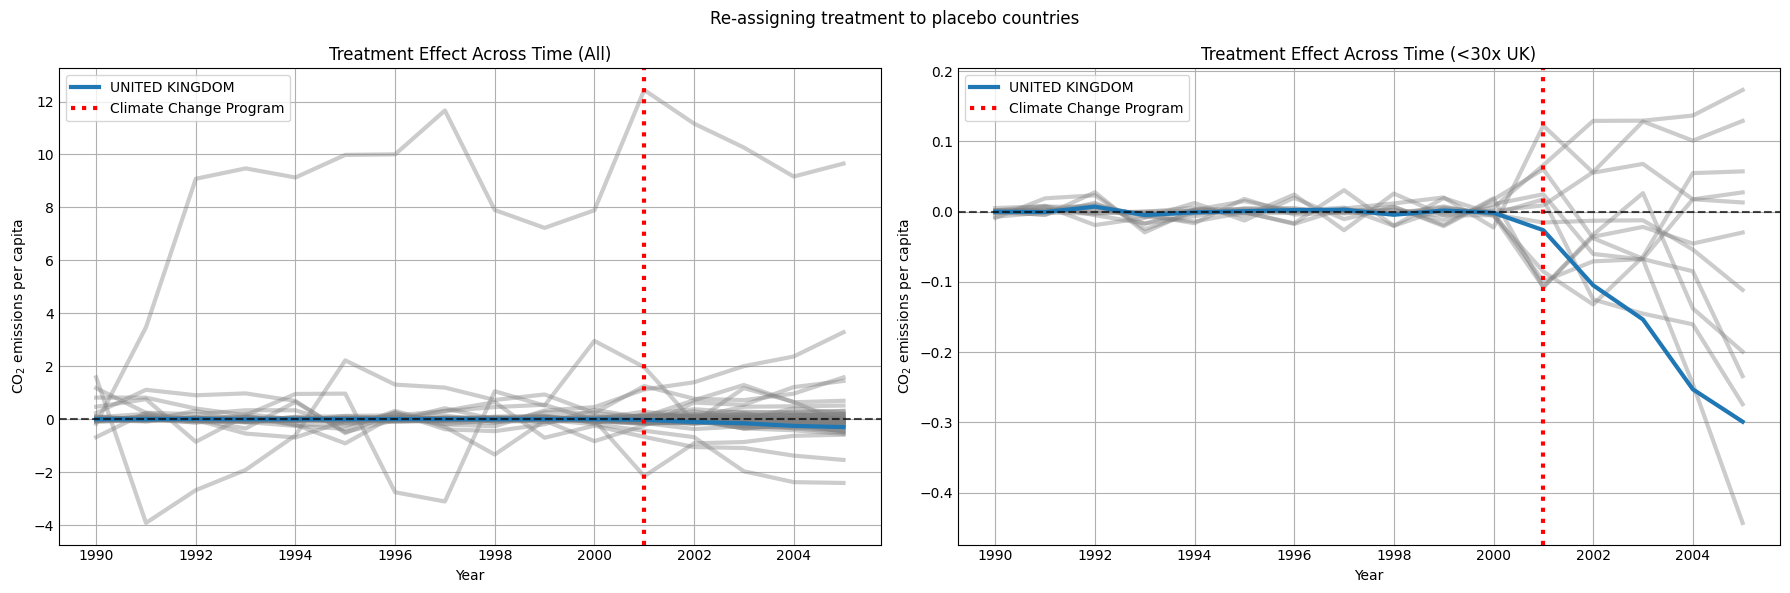

In [15]:
error_multiplier = 30

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Re-assigning treatment to placebo countries')

# Plot treatment effect for each country
for nation in placebo_experiments:
    ax1.plot(
        nation['year'], 
        nation['per_capita_CO2'] - nation['synthetic'], 
        color='gray', 
        lw=3, 
        alpha=0.4
    )

ax1.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'] - synthetic_control,
    lw=3,
    label=TARGET_COUNTRY,
)
ax1.axvline(x=INTERVENTION_YEAR, linestyle=':', lw=3, color='red', label="Climate Change Program")
ax1.axhline(y=0, linestyle='--', color='black', alpha=0.7)
ax1.set_xlabel('Year')
ax1.set_ylabel('CO$_2$ emissions per capita')
ax1.set_title('Treatment Effect Across Time (All)')
ax1.legend()

# Plot treatment only for countries with pre-treatment MSPE no greater than 30x the UK
pre_error_united_kingdom = pre_intervention_error(calculate_synthetic_control(nation=TARGET_COUNTRY, data=data))

for nation in placebo_experiments:
    if pre_intervention_error(nation) < pre_error_united_kingdom * error_multiplier:
        ax2.plot(nation['year'], nation['per_capita_CO2'] - nation['synthetic'], color='gray',  lw=3, alpha=0.4)

ax2.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'] - synthetic_control,
    lw=3,
    label=TARGET_COUNTRY,
)
ax2.axvline(x=INTERVENTION_YEAR, linestyle=":", lw=3, color='red', label="Climate Change Program")
ax2.axhline(y=0, linestyle="--", color='black', alpha=0.7)
ax2.set_xlabel('Year')
ax2.set_ylabel('CO$_2$ emissions per capita')
ax2.set_title('Treatment Effect Across Time (<30x UK)')
ax2.legend()

plt.tight_layout()
plt.show()

Compute the ratio statistics and plot

In [16]:
# Compute ratio statistics for all countries
ratios = [post_to_pre_intervention_ratio(nation) for nation in all_experiments]

# Zip the ratios with countries and sort them
sorted_pairs = sorted(zip(ratios, DONOR_COUNTRIES + [TARGET_COUNTRY]))

# Unzip the sorted pairs into two separate lists
sorted_ratios, sorted_strings = zip(*sorted_pairs)

# Extract the ratio statistic for the treatment unit (United Kingdom)
target_country_ratio = ratios[(DONOR_COUNTRIES + [TARGET_COUNTRY]).index(TARGET_COUNTRY)]


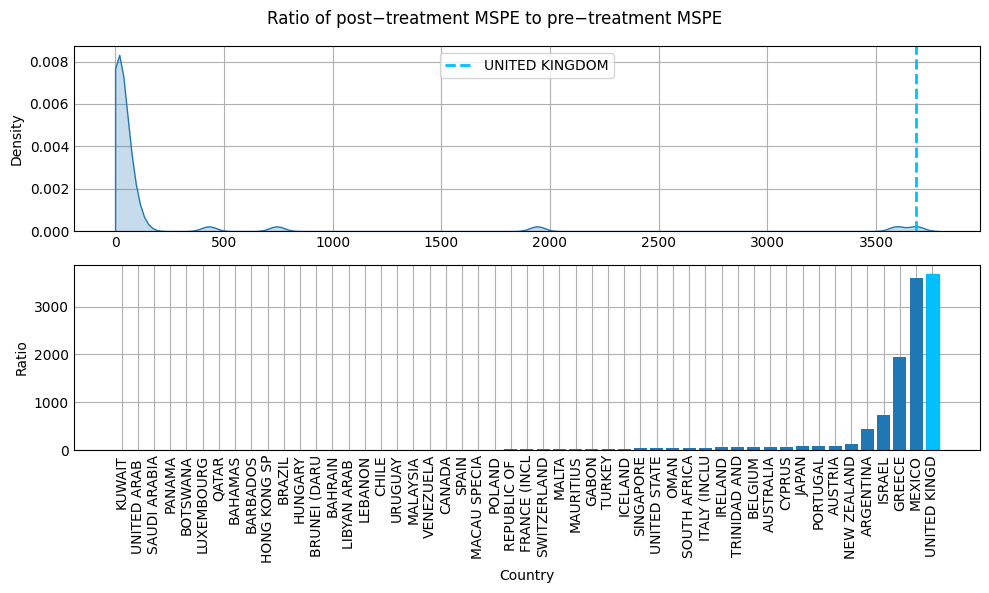

In [17]:
# Create a figure and a 2x1 grid of subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
fig.suptitle('Ratio of post−treatment MSPE to pre−treatment MSPE')

# Plot distribution of the ratio statistic for all countries
sns.kdeplot(ratios, bw_adjust=0.1, clip=(0, None), lw=1, fill=True, ax=axes[0])

axes[0].axvline(x=target_country_ratio, linestyle='--', lw=2, color='deepskyblue', label=TARGET_COUNTRY)
axes[0].legend(loc='upper center')

# Plot the ratio statistic for all countries in the sample
bars = axes[1].bar(sorted_strings, sorted_ratios)
for bar, country in zip(bars, sorted_strings):
    if country == 'UNITED KINGDOM':
        bar.set_color('deepskyblue')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Ratio')

x_ticks_labels = [label[:12] for label in sorted_strings]  # Truncate the country names to 12 characters

axes[1].set_xticks(range(len(x_ticks_labels)))
axes[1].set_xticklabels(x_ticks_labels, rotation=90)

plt.tight_layout()
plt.show()

Perform leave-one-out (LOO) experiments

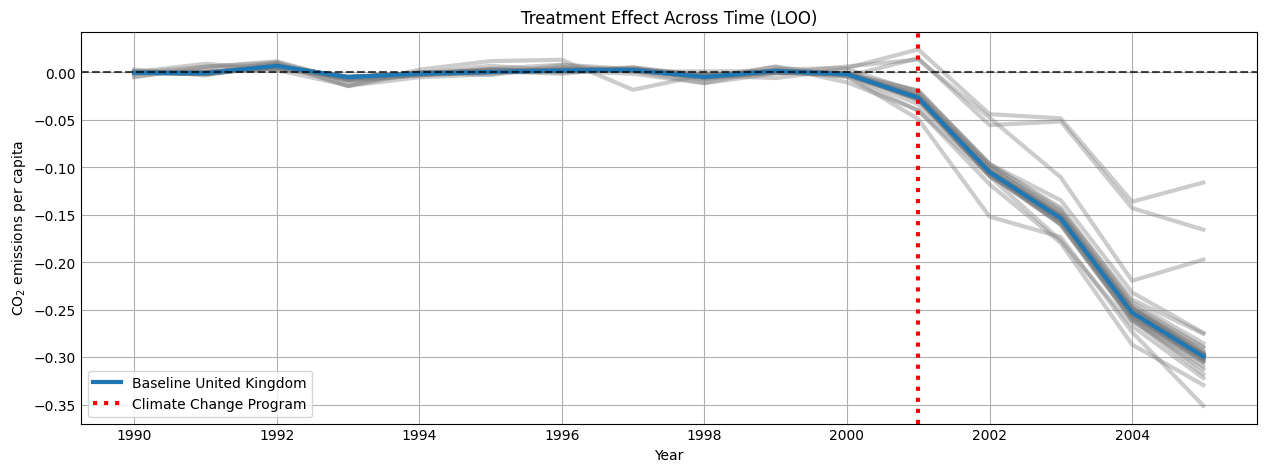

In [18]:
leave_one_out_experiments = [calculate_synthetic_control(nation=TARGET_COUNTRY, data=data, leave_one_out=[nation]) for nation in DONOR_COUNTRIES]

plt.figure(figsize=(12,4))

for nation in leave_one_out_experiments:
    plt.plot(nation['year'], nation['per_capita_CO2'] - nation['synthetic'], color='gray', lw=3, alpha=0.4)

plt.plot(
    data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
    data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'] - synthetic_control,
    lw=3,
    label='Baseline United Kingdom',
)

plt.axvline(x=INTERVENTION_YEAR, linestyle=':', lw=3, color='red', label="Climate Change Program")
plt.axhline(y=0, linestyle='--', color='black', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('CO$_2$ emissions per capita')
plt.title('Treatment Effect Across Time (LOO)')
plt.legend()

plt.show()

Perform placebo 'in time' experiments

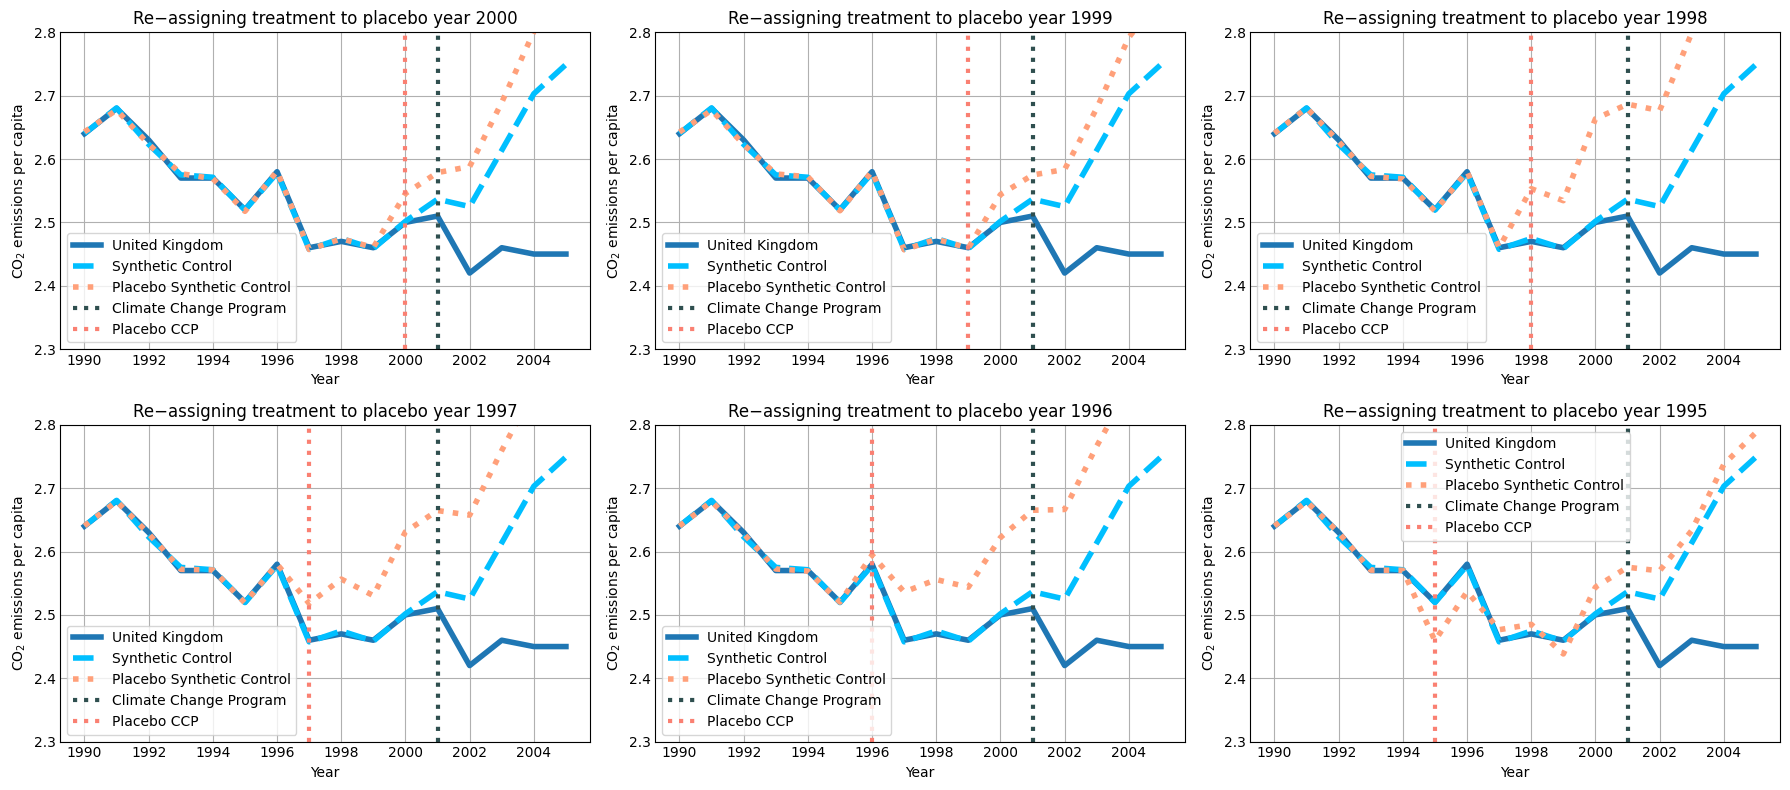

In [19]:
# Define the feature(s) to be used
features = ['per_capita_CO2']

# Number of plots
n_plots = 6

# Create a grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

# Loop through how many years back to re-assign the treatment
for i, shift_back in enumerate(range(1, n_plots + 1)):
    ax = axes[i]

    # Create a pre-intervention feature matrix
    pre_intervention_feature_matrix = data.query(f'year < {INTERVENTION_YEAR - shift_back}') \
                .pivot(index='nation', columns='year') \
                [features] \
                .T

    # Extract values for the target country and control features
    X = pre_intervention_feature_matrix.drop(columns=TARGET_COUNTRY).values 
    y = pre_intervention_feature_matrix[TARGET_COUNTRY].values

    # Apply the optimize_weights function to get the weights for the control units
    weights_synthetic_control = optimize_weights(X, y)

    synthetic_control_shifted = data \
        .query(f'nation != "{TARGET_COUNTRY}"') \
        .pivot(index='year', columns='nation') \
        ['per_capita_CO2'] \
        .values \
        .dot(weights_synthetic_control)
    
    # Plotting on the placebo 'in time' experiments
    ax.plot(
        data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
        data.query(f'nation == "{TARGET_COUNTRY}"')['per_capita_CO2'], label='United Kingdom',
        lw=4,
    )
    ax.plot(
        data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
        synthetic_control, label='Synthetic Control',
        linestyle="--",
        lw=4,
        color='deepskyblue'
    )
    ax.plot(
        data.query(f'nation == "{TARGET_COUNTRY}"')['year'], 
        synthetic_control_shifted, label='Placebo Synthetic Control',
        linestyle=':',
        lw=4,
        color='lightsalmon'
    )

    ax.axvline(x=INTERVENTION_YEAR, linestyle=':', color='darkslategrey', lw=3, label='Climate Change Program')
    ax.axvline(x=INTERVENTION_YEAR - shift_back, linestyle=':', color='salmon', lw=3, label='Placebo CCP')
    
    ax.set_xlabel('Year')
    ax.set_ylabel('CO$_2$ emissions per capita')
    ax.set_title(f'Re−assigning treatment to placebo year {INTERVENTION_YEAR - shift_back}')
    ax.set_ylim(2.3, 2.8)
    ax.legend()
    
plt.tight_layout()
plt.show()